Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
# from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/cnn/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/cnn/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test, label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

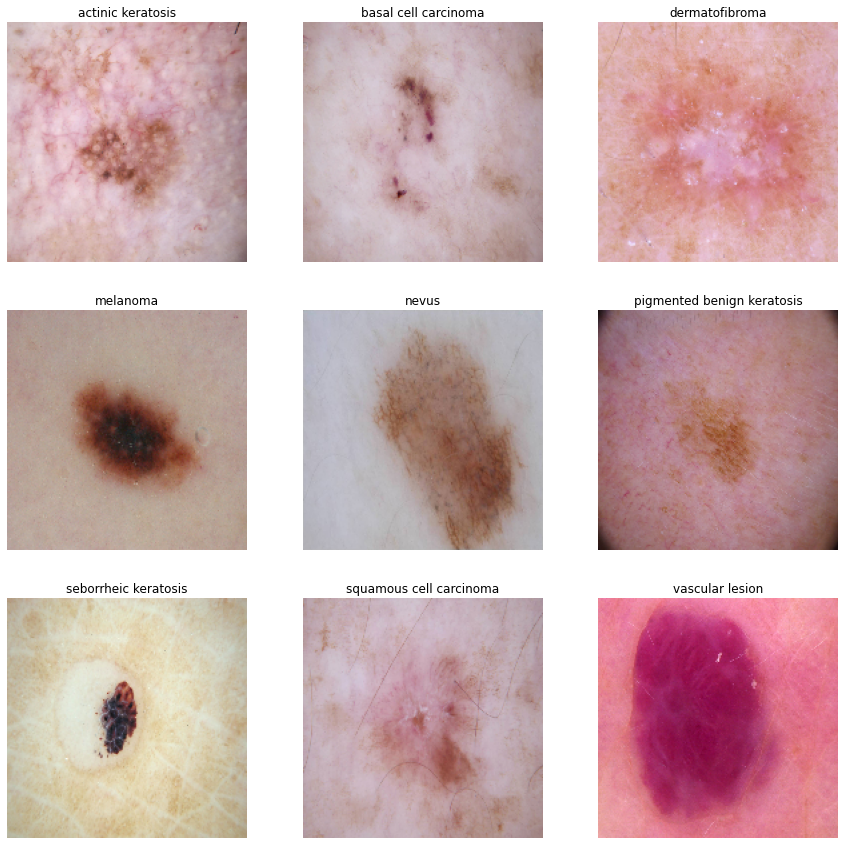

In [10]:
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fourth Convulation Layer
model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### choosing an appropirate optimiser and loss function
#Compile the Model


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

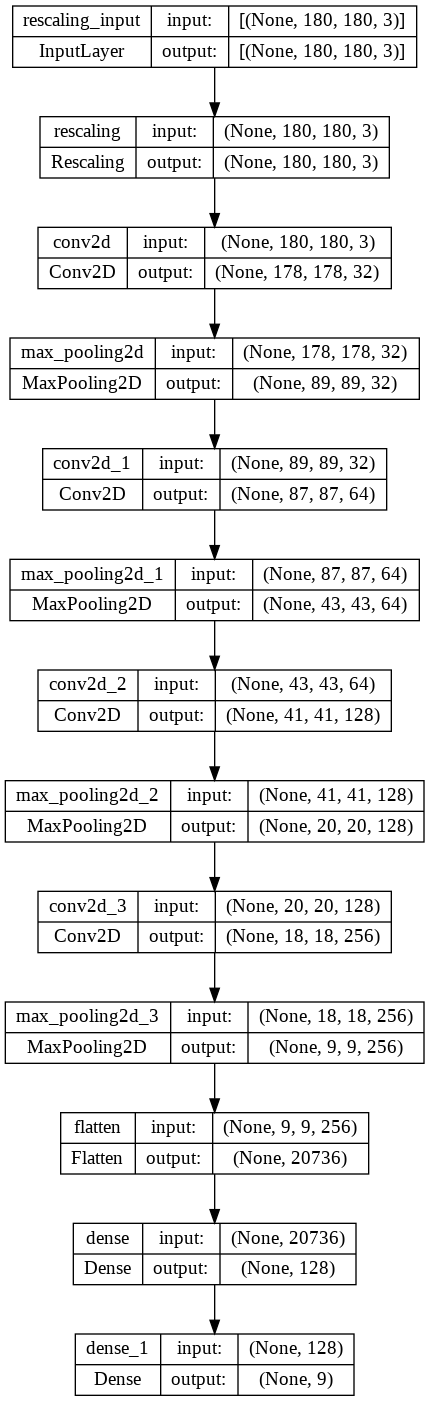

In [15]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
### Train the model

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 632s 2s/step - loss: 2.0302 - accuracy: 0.2327 - val_loss: 1.9029 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.8730 - accuracy: 0.3131 - val_loss: 1.6986 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.7145 - accuracy: 0.3638 - val_loss: 1.5861 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6163 - accuracy: 0.4202 - val_loss: 1.7478 - val_accuracy: 0.3960
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5531 - accuracy: 0.4559 - val_loss: 1.6046 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4467 - accuracy: 0.4989 - val_loss: 1.4461 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3629 - accuracy: 0.5257 - val_loss: 1.3798 - val_accuracy: 0.5190
Epoch 8/20
56

### Visualizing training results

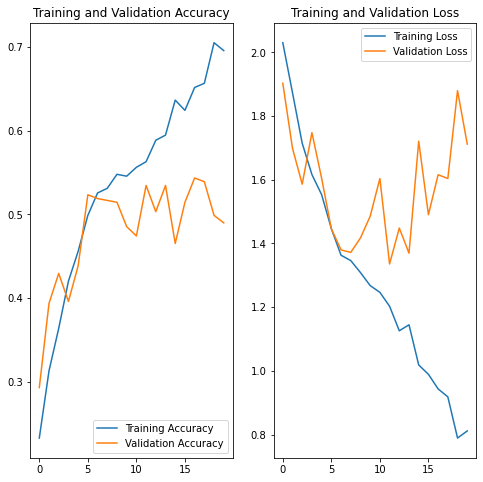

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### This is a case of overfitting as training accuracy is far higher than validation accuracy. We will apply an augmentation layer to overcome this.
We will also use a drop out layer and remove one convolution layers

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.3),
])



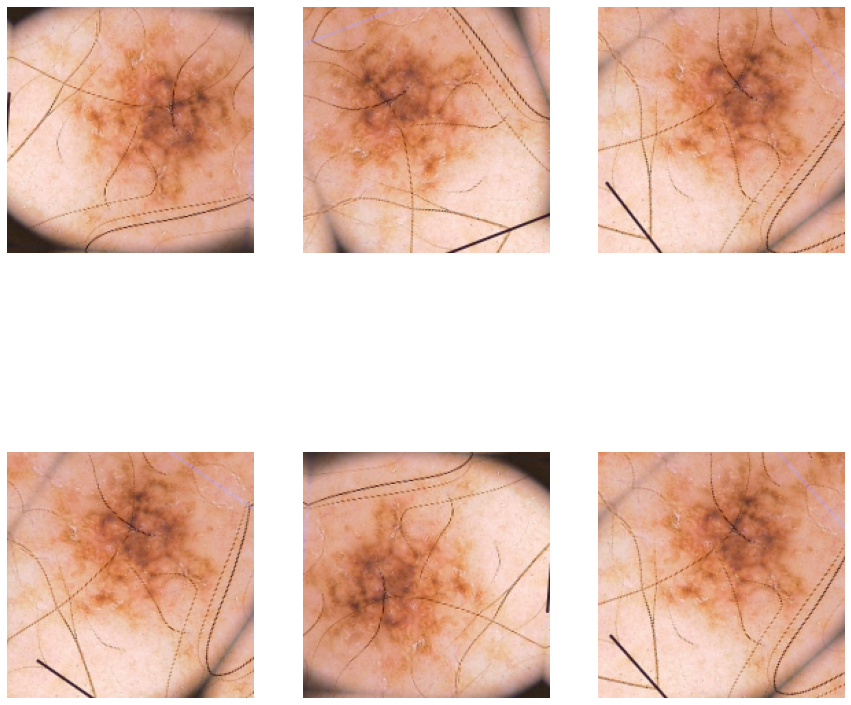

In [19]:
#Visualize one image randomly with augmnetation strategy 
plt.figure(figsize=(15,15))

for images, _ in train_ds.take(1):
  for i in range(6):
    augmented_images=data_augmentation(images,training=True)
    ax=plt.subplot(2,3,i+1)
    plt.imshow(augmented_images[2].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()
model.add(layers.RandomRotation(0.3),)
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Dropout layer with 25% drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))






### Compiling the model

In [21]:

### Todo, choose an appropirate optimiser and loss function
#Compile the Model

#Adam optimization

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])



### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 3s 43ms/step - loss: 2.0437 - accuracy: 0.2444 - val_loss: 1.8165 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.7606 - accuracy: 0.3510 - val_loss: 1.6184 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6529 - accuracy: 0.3862 - val_loss: 1.6869 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5973 - accuracy: 0.4146 - val_loss: 1.4950 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4867 - accuracy: 0.4743 - val_loss: 1.4312 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4434 - accuracy: 0.4967 - val_loss: 1.4183 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4283 - accuracy: 0.4916 - val_loss: 1.4519 - val_accuracy: 0.4989
Epoch 8/20
56

### Visualizing the results

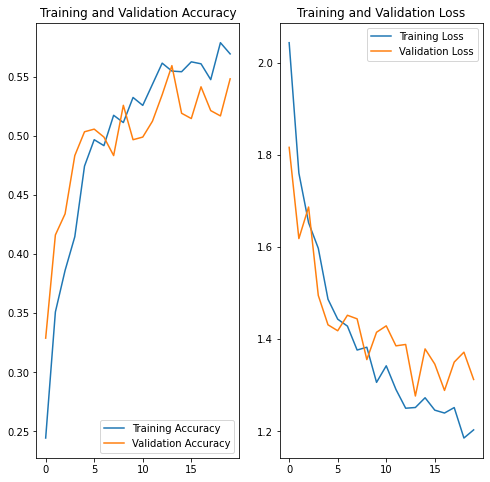

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
The overfit has been solved using the augmentation and dropout strategy byut the overally accuracy is not good. This can be called underfit and this may be because of insufficent data and class imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,melanoma,438
2,dermatofibroma,95
3,basal cell carcinoma,376
4,vascular lesion,139
5,nevus,357
6,actinic keratosis,114
7,seborrheic keratosis,77
8,squamous cell carcinoma,181


#### findings here: 
#### - Seborrheic Keratosis has the least samples
#### - pigmented benign keratosis	and melanoma dominate the dataset


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/gdrive/MyDrive/cnn/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC4E606DB10>: 100%|██████████| 500/500 [00:20<00:00, 24.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC4E6124990>: 100%|██████████| 500/500 [00:21<00:00, 23.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4E606D490>: 100%|██████████| 500/500 [00:21<00:00, 23.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC4E603DFD0>: 100%|██████████| 500/500 [01:46<00:00,  4.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FC4E607E4D0>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC4DFBD5AD0>: 100%|██████████| 500/500 [00:22<00:00, 22.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC4FC622810>: 100%|██████████| 500/500 [00:41<00:00, 12.01 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4E618DB10>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4E619AD50>: 100%|██████████| 500/500 [00:18<00:00, 27.32 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027820.jpg_bb693cbb-0a37-49fd-a28e-81dfeed36651.jpg',
 '/content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026803.jpg_000519e6-c8df-4d61-b8bd-fe25e33d0dc4.jpg',
 '/content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027370.jpg_d74cf78d-32ab-44d9-ae5c-a2e802e0c644.jpg',
 '/content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027042.jpg_e82bc7c6-f718-4c62-b9a4-4c5ad458cffc.jpg',
 '/content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026443.jpg_9f71804a-1840-4beb-9172-80ea8ba3639e.jpg',
 '/content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026827.jpg_6cd5cd52-25a2-42a2-9386-1e7c7afbfcd9.jpg',
 '/c

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/cnn/Train/pigmented be...,pigmented benign keratosis
1,/content/gdrive/MyDrive/cnn/Train/pigmented be...,pigmented benign keratosis
2,/content/gdrive/MyDrive/cnn/Train/pigmented be...,pigmented benign keratosis
3,/content/gdrive/MyDrive/cnn/Train/pigmented be...,pigmented benign keratosis
4,/content/gdrive/MyDrive/cnn/Train/pigmented be...,pigmented benign keratosis
...,...,...
4495,/content/gdrive/MyDrive/cnn/Train/squamous cel...,squamous cell carcinoma
4496,/content/gdrive/MyDrive/cnn/Train/squamous cel...,squamous cell carcinoma
4497,/content/gdrive/MyDrive/cnn/Train/squamous cel...,squamous cell carcinoma
4498,/content/gdrive/MyDrive/cnn/Train/squamous cel...,squamous cell carcinoma


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [33]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/cnn/Train")
# data_dir_train="path to directory with training data + data created using augmentor"
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   # subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset="validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [35]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))



#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 128)      

####  Compile your model (Choose optimizer and loss function appropriately)

In [36]:

### Todo, choose an appropirate optimiser and loss function
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


#### ****  Train your model

In [37]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 41s 234ms/step - loss: 1.9262 - accuracy: 0.2708 - val_loss: 1.5603 - val_accuracy: 0.4039
Epoch 2/30
169/169 [==============================] - 32s 186ms/step - loss: 1.5384 - accuracy: 0.4099 - val_loss: 1.4099 - val_accuracy: 0.4736
Epoch 3/30
169/169 [==============================] - 33s 190ms/step - loss: 1.3891 - accuracy: 0.4759 - val_loss: 1.2801 - val_accuracy: 0.5019
Epoch 4/30
169/169 [==============================] - 32s 183ms/step - loss: 1.2845 - accuracy: 0.5139 - val_loss: 1.2569 - val_accuracy: 0.5271
Epoch 5/30
169/169 [==============================] - 34s 198ms/step - loss: 1.1765 - accuracy: 0.5569 - val_loss: 1.0904 - val_accuracy: 0.5813
Epoch 6/30
169/169 [==============================] - 32s 181ms/step - loss: 1.0943 - accuracy: 0.5946 - val_loss: 1.1637 - val_accuracy: 0.5761
Epoch 7/30
169/169 [==============================] - 44s 253ms/step - loss: 0.9932 - accuracy: 0.6230 - val_loss: 0.9418 - val_ac

####   Visualize the model results

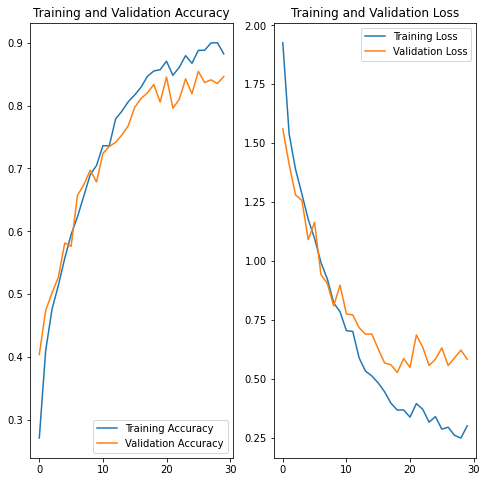

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Final Analysis




Observations
- The base model is observed to underfit as the validation accuracy is very low
- Augmentation and Dropout layers are introduced to get rid of the underfitting
- The dataset are not evenly divided into different classes. Some classes are dominant and some are sparse. There is a class imbalance that we need to resolve
- The dataset doesnot have enough data. So Augmentor strategy to augment the number of images is required. The final model has good training, test accuracy


We got rid of over fitting by the augmentation layer and drop-out layers.
Class imbalance was fixed with the help of augmentor.
The overall accuracy is good after the third model.



The final model has the below layers applied:

Rescalling Layer - To rescale an input in the [0, 255] range to be in the [0, 1] range.
Convolutional Layer - Convolutional layers apply a convolution operation to the input, passing the result to the next layer. 
Pooling Layer - Pooling layers are used to reduce the dimensions of the feature maps.
Dropout Layer - The Dropout layer randomly sets input units to 0 which helps prevent overfitting.
Flatten Layer - Flattening is converting the data into a 1-dimensional array for inputting it to the next layer.
Dense Layer - The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer.
Activation Function(ReLU) - The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.
Activation Function(Softmax) - The softmax function is used as the activation function in the output layer of neural network models that predict a multinomial probability distribution. The main advantage of using Softmax is the output probabilities range. The range will 0 to 1, and the sum of all the probabilities will be equal to one.

